In [59]:
# Import Colab's Drive helper
from google.colab import drive

# Mount (attach) your Google Drive at this folder path inside Colab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
# Define project folder paths (base/csv/output) and verify the folders + dataset files exist in Drive.
import os
BASE_DIR = "/content/drive/MyDrive/ds_ice"
CSV_DIR = os.path.join(BASE_DIR, "csv_files")
OUT_DIR = os.path.join(BASE_DIR, "outputs")
print("BASE exists:", os.path.exists(BASE_DIR))
print("CSV files:", os.listdir(CSV_DIR))
print("OUT exists:", os.path.exists(OUT_DIR))

BASE exists: True
CSV files: ['fear_greed_index.csv', 'historical_data.csv']
OUT exists: True


In [61]:
# Load both datasets from Drive and show basic preview + shape to confirm they loaded correctly.
import pandas as pd

fear_greed_path = f"{CSV_DIR}/fear_greed_index.csv"
historical_path = f"{CSV_DIR}/historical_data.csv"

fear_greed = pd.read_csv(fear_greed_path)
historical = pd.read_csv(historical_path)

print("fear_greed shape:", fear_greed.shape)
print("historical shape:", historical.shape)

display(fear_greed.head())
display(historical.head())

fear_greed shape: (2644, 4)
historical shape: (211224, 16)


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [62]:
# Quick dataset health check: columns, datatypes, missing values, and duplicate rows for both datasets.
def quick_check(df, name):
    print(f"\n===== {name} =====")
    print("Columns:", list(df.columns))
    print("\nDtypes:")
    print(df.dtypes)
    print("\nMissing values (top):")
    miss = df.isna().sum().sort_values(ascending=False)
    print(miss[miss > 0].head(20))  # show only columns that have missing values
    print("\nDuplicate rows:", df.duplicated().sum())

quick_check(fear_greed, "fear_greed")
quick_check(historical, "historical")


===== fear_greed =====
Columns: ['timestamp', 'value', 'classification', 'date']

Dtypes:
timestamp          int64
value              int64
classification    object
date              object
dtype: object

Missing values (top):
Series([], dtype: int64)

Duplicate rows: 0

===== historical =====
Columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']

Dtypes:
Account              object
Coin                 object
Execution Price     float64
Size Tokens         float64
Size USD            float64
Side                 object
Timestamp IST        object
Start Position      float64
Direction            object
Closed PnL          float64
Transaction Hash     object
Order ID              int64
Crossed                bool
Fee                 float64
Trade ID            float64
Timestamp           float64
dtype: object

Missing valu

In [63]:
# Convert date columns to proper datetime and create a common daily key (trade_date) for merging sentiment with trades.
fear_greed["date"] = pd.to_datetime(fear_greed["date"])

historical["Timestamp IST"] = pd.to_datetime(historical["Timestamp IST"], format="%d-%m-%Y %H:%M")
historical["trade_date"] = historical["Timestamp IST"].dt.normalize()  # midnight date (YYYY-MM-DD)

print("fear_greed date dtype:", fear_greed["date"].dtype, "| range:", fear_greed["date"].min(), "to", fear_greed["date"].max())
print("historical Timestamp IST dtype:", historical["Timestamp IST"].dtype)
print("historical trade_date dtype:", historical["trade_date"].dtype, "| range:", historical["trade_date"].min(), "to", historical["trade_date"].max())

fear_greed date dtype: datetime64[ns] | range: 2018-02-01 00:00:00 to 2025-05-02 00:00:00
historical Timestamp IST dtype: datetime64[ns]
historical trade_date dtype: datetime64[ns] | range: 2023-05-01 00:00:00 to 2025-05-01 00:00:00


In [64]:
# Merge trades with fear/greed by date and report how many trades got matched with sentiment.
fg_daily = fear_greed[["date", "value", "classification"]].rename(columns={"date": "trade_date"})

merged = historical.merge(fg_daily, on="trade_date", how="left")

print("Total trades:", len(historical))
print("Trades matched with sentiment:", merged["value"].notna().sum())
print("Match rate (%):", round(100 * merged["value"].notna().mean(), 2))

display(merged[["trade_date", "Timestamp IST", "Coin", "Side", "Closed PnL", "value", "classification"]].head())

Total trades: 211224
Trades matched with sentiment: 211218
Match rate (%): 100.0


,trade_date,Timestamp IST,Coin,Side,Closed PnL,value,classification
0,2024-12-02,2024-12-02 22:50:00,@107,BUY,0.0,80.0,Extreme Greed
1,2024-12-02,2024-12-02 22:50:00,@107,BUY,0.0,80.0,Extreme Greed
2,2024-12-02,2024-12-02 22:50:00,@107,BUY,0.0,80.0,Extreme Greed
3,2024-12-02,2024-12-02 22:50:00,@107,BUY,0.0,80.0,Extreme Greed
4,2024-12-02,2024-12-02 22:50:00,@107,BUY,0.0,80.0,Extreme Greed


In [65]:
# Compute overall performance metrics + per-account (trader) summary: total PnL, win rate, avg PnL, trade count.
m = merged.copy()

# Ensure Closed PnL is numeric (safety)
m["Closed PnL"] = pd.to_numeric(m["Closed PnL"], errors="coerce")

overall = {
    "trades": int(m["Closed PnL"].notna().sum()),
    "total_pnl": float(m["Closed PnL"].sum()),
    "avg_pnl_per_trade": float(m["Closed PnL"].mean()),
    "median_pnl_per_trade": float(m["Closed PnL"].median()),
    "win_rate_%": float((m["Closed PnL"] > 0).mean() * 100),
    "loss_rate_%": float((m["Closed PnL"] < 0).mean() * 100),
    "breakeven_%": float((m["Closed PnL"] == 0).mean() * 100),
}
print("OVERALL METRICS")
for k, v in overall.items():
    print(f"{k}: {v}")

account_summary = (
    m.groupby("Account")
     .agg(
         trades=("Closed PnL", "count"),
         total_pnl=("Closed PnL", "sum"),
         avg_pnl=("Closed PnL", "mean"),
         median_pnl=("Closed PnL", "median"),
         win_rate=("Closed PnL", lambda s: (s > 0).mean()),
     )
     .sort_values("total_pnl", ascending=False)
)

account_summary["win_rate_%"] = (account_summary["win_rate"] * 100).round(2)
account_summary = account_summary.drop(columns=["win_rate"])

display(account_summary.head(10))

OVERALL METRICS
trades: 211224
total_pnl: 10296958.943436
avg_pnl_per_trade: 48.74900079269401
median_pnl_per_trade: 0.0
win_rate_%: 41.12648183918494
loss_rate_%: 8.30350717721471
breakeven_%: 50.57001098360034


,trades,total_pnl,avg_pnl,median_pnl,win_rate_%
Account,,,,,
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,14733,2.143383e+06,145.481748,0.000000,33.71
0x083384f897ee0f19899168e3b1bec365f52a9012,3818,1.600230e+06,419.127768,0.000000,35.96
0xbaaaf6571ab7d571043ff1e313a9609a10637864,21192,9.401638e+05,44.364091,0.000000,46.76
0x513b8629fe877bb581bf244e326a047b249c4ff1,12236,8.404226e+05,68.684419,0.000000,40.12
0xbee1707d6b44d4d52bfe19e41f8a828645437aab,40184,8.360806e+05,20.806305,0.000000,42.82
0x4acb90e786d897ecffb614dc822eb231b4ffb9f4,4356,6.777471e+05,155.589314,0.000000,48.62
0x72743ae2822edd658c0c50608fd7c5c501b2afbd,1590,4.293556e+05,270.034947,0.000000,34.59
0x430f09841d65beb3f27765503d0f850b8bce7713,1237,4.165419e+05,336.735548,0.000000,48.42
0x72c6a4624e1dffa724e6d00d64ceae698af892a0,1430,4.030115e+05,281.826227,0.000000,30.63


In [66]:
# Summarize performance by sentiment classification (Extreme Fear → Extreme Greed) and show trade counts + PnL stats.
sent_summary = (
    m.groupby("classification")
     .agg(
         trades=("Closed PnL", "count"),
         total_pnl=("Closed PnL", "sum"),
         avg_pnl=("Closed PnL", "mean"),
         median_pnl=("Closed PnL", "median"),
         win_rate=("Closed PnL", lambda s: (s > 0).mean()),
     )
     .sort_values("trades", ascending=False)
)

sent_summary["win_rate_%"] = (sent_summary["win_rate"] * 100).round(2)
sent_summary = sent_summary.drop(columns=["win_rate"])

display(sent_summary)

,trades,total_pnl,avg_pnl,median_pnl,win_rate_%
classification,,,,,
Fear,61837,3.357155e+06,54.290400,0.0,42.08
Greed,50303,2.150129e+06,42.743559,0.0,38.48
Extreme Greed,39992,2.715171e+06,67.892861,0.0,46.49
Neutral,37686,1.292921e+06,34.307718,0.0,39.70
Extreme Fear,21400,7.391102e+05,34.537862,0.0,37.06


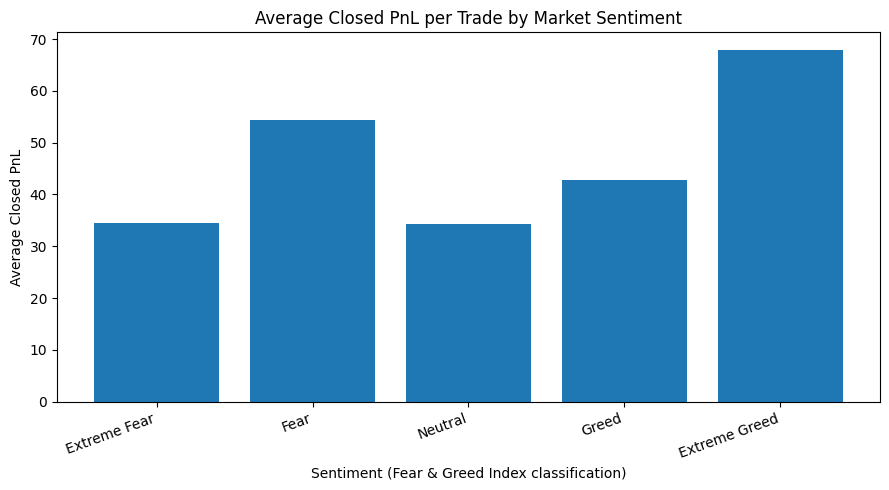

Saved: /content/drive/MyDrive/ds_ice/outputs/chart_avg_pnl_by_sentiment.png


In [67]:
# Plot avg PnL per trade by sentiment classification and save the figure into outputs/.
import matplotlib.pyplot as plt

order = ["Extreme Fear", "Fear", "Neutral", "Greed", "Extreme Greed"]  # logical sentiment order
plot_df = sent_summary.reindex([c for c in order if c in sent_summary.index])

plt.figure(figsize=(9, 5))
plt.bar(plot_df.index, plot_df["avg_pnl"])
plt.title("Average Closed PnL per Trade by Market Sentiment")
plt.xlabel("Sentiment (Fear & Greed Index classification)")
plt.ylabel("Average Closed PnL")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()

chart1_path = f"{OUT_DIR}/chart_avg_pnl_by_sentiment.png"
plt.savefig(chart1_path, dpi=200)
plt.show()

print("Saved:", chart1_path)

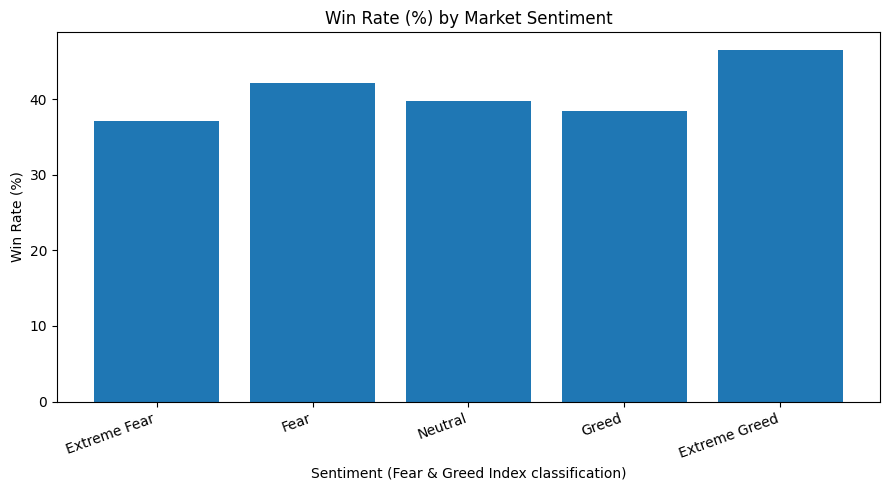

Saved: /content/drive/MyDrive/ds_ice/outputs/chart_win_rate_by_sentiment.png


In [68]:
# Plot win rate (%) by sentiment classification and save the figure into outputs/.
import matplotlib.pyplot as plt

order = ["Extreme Fear", "Fear", "Neutral", "Greed", "Extreme Greed"]
plot_df = sent_summary.reindex([c for c in order if c in sent_summary.index])

plt.figure(figsize=(9, 5))
plt.bar(plot_df.index, plot_df["win_rate_%"])
plt.title("Win Rate (%) by Market Sentiment")
plt.xlabel("Sentiment (Fear & Greed Index classification)")
plt.ylabel("Win Rate (%)")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()

chart2_path = f"{OUT_DIR}/chart_win_rate_by_sentiment.png"
plt.savefig(chart2_path, dpi=200)
plt.show()

print("Saved:", chart2_path)

Correlation (sentiment value vs Closed PnL): 0.0081


/tmp/ipython-input-621/2317095042.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary = df.groupby("sent_bin").agg(


,trades,avg_pnl,win_rate
sent_bin,,,
0-20,13139,52.092245,41.608950
20-40,59426,39.158849,40.495743
40-60,58035,49.737662,39.862152
60-80,66303,43.841892,41.316381
80-100,14315,101.265736,47.523577


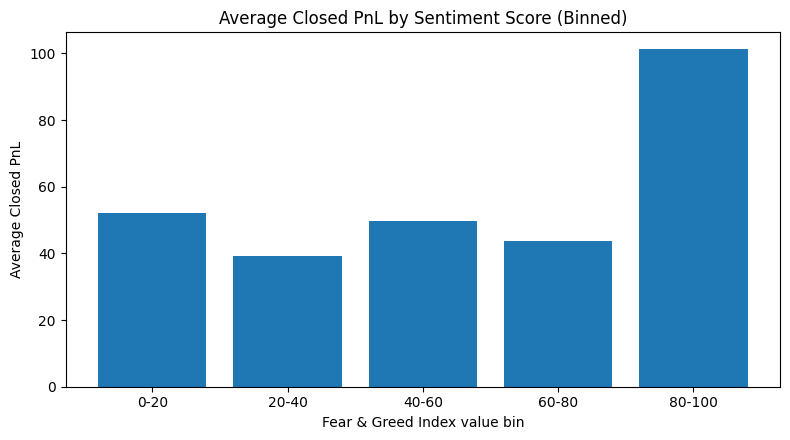

Saved: /content/drive/MyDrive/ds_ice/outputs/chart_avg_pnl_by_sentiment_bins.png


In [69]:
# Analyze relationship between numeric sentiment score (0–100) and PnL using correlation + binned averages.
import numpy as np
import matplotlib.pyplot as plt

df = m.dropna(subset=["value", "Closed PnL"]).copy()

corr = df["value"].corr(df["Closed PnL"])
print("Correlation (sentiment value vs Closed PnL):", round(corr, 4))

# Create 5 bins similar to sentiment buckets: 0-20, 20-40, 40-60, 60-80, 80-100
bins = [0, 20, 40, 60, 80, 100]
labels = ["0-20", "20-40", "40-60", "60-80", "80-100"]
df["sent_bin"] = pd.cut(df["value"], bins=bins, labels=labels, include_lowest=True, right=True)

bin_summary = df.groupby("sent_bin").agg(
    trades=("Closed PnL", "count"),
    avg_pnl=("Closed PnL", "mean"),
    win_rate=("Closed PnL", lambda s: (s > 0).mean() * 100),
)

display(bin_summary)

plt.figure(figsize=(8, 4.5))
plt.bar(bin_summary.index.astype(str), bin_summary["avg_pnl"])
plt.title("Average Closed PnL by Sentiment Score (Binned)")
plt.xlabel("Fear & Greed Index value bin")
plt.ylabel("Average Closed PnL")
plt.tight_layout()

chart3_path = f"{OUT_DIR}/chart_avg_pnl_by_sentiment_bins.png"
plt.savefig(chart3_path, dpi=200)
plt.show()

print("Saved:", chart3_path)

In [70]:
# Save the sentiment-bin performance summary to outputs as a CSV for the final report.
bin_csv_path = f"{OUT_DIR}/sentiment_bin_performance.csv"
bin_summary.to_csv(bin_csv_path)
print("Saved:", bin_csv_path)

# Also save the classification summary table (Extreme Fear/Fear/Neutral/Greed/Extreme Greed)
class_csv_path = f"{OUT_DIR}/sentiment_class_performance.csv"
sent_summary.to_csv(class_csv_path)
print("Saved:", class_csv_path)

Saved: /content/drive/MyDrive/ds_ice/outputs/sentiment_bin_performance.csv
Saved: /content/drive/MyDrive/ds_ice/outputs/sentiment_class_performance.csv


In [71]:
# Save overall metrics + top traders table to outputs so the report can reference them.
import pandas as pd

overall_path = f"{OUT_DIR}/overall_metrics.csv"
pd.DataFrame([overall]).to_csv(overall_path, index=False)
print("Saved:", overall_path)

top_traders_path = f"{OUT_DIR}/top_traders_by_total_pnl.csv"
account_summary.head(50).to_csv(top_traders_path)  # top 50 for report
print("Saved:", top_traders_path)

Saved: /content/drive/MyDrive/ds_ice/outputs/overall_metrics.csv
Saved: /content/drive/MyDrive/ds_ice/outputs/top_traders_by_total_pnl.csv


In [72]:
# Install the PDF library (ReportLab) needed to generate DSReport.pdf
!pip -q install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.3 MB/s eta 0:00:00


In [73]:
# Create DSReport.pdf in outputs/ using your already-generated charts + CSVs.

import os
import pandas as pd

from reportlab.lib.pagesizes import A4
from reportlab.lib.units import inch
from reportlab.pdfgen import canvas
from reportlab.lib.utils import ImageReader

# ---- Paths (match your project) ----
BASE_DIR = "/content/drive/MyDrive/ds_ice"
OUT_DIR  = os.path.join(BASE_DIR, "outputs")
REPORT_PATH = os.path.join(OUT_DIR, "DSReport.pdf")

# ---- Charts created earlier ----
CHART1 = os.path.join(OUT_DIR, "chart_avg_pnl_by_sentiment.png")
CHART2 = os.path.join(OUT_DIR, "chart_win_rate_by_sentiment.png")
CHART3 = os.path.join(OUT_DIR, "chart_avg_pnl_by_sentiment_bins.png")

# ---- Tables created earlier ----
TBL_CLASS = os.path.join(OUT_DIR, "sentiment_class_performance.csv")
TBL_BIN   = os.path.join(OUT_DIR, "sentiment_bin_performance.csv")
TBL_TOP   = os.path.join(OUT_DIR, "top_traders_by_total_pnl.csv")
TBL_OVER  = os.path.join(OUT_DIR, "overall_metrics.csv")

# ---- Page setup ----
W, H = A4
M = 48  # margin

def file_ok(path):
    return os.path.exists(path) and os.path.getsize(path) > 0

def draw_title(c, text, y):
    c.setFont("Helvetica-Bold", 14)
    c.drawString(M, y, text)
    return y - 18

def draw_subtitle(c, text, y):
    c.setFont("Helvetica-Bold", 11)
    c.drawString(M, y, text)
    return y - 14

def draw_para(c, lines, y, font="Helvetica", size=10, leading=14):
    c.setFont(font, size)
    for line in lines:
        c.drawString(M, y, line)
        y -= leading
    return y - 6

def draw_kv(c, pairs, y):
    c.setFont("Helvetica", 10)
    for k, v in pairs:
        c.drawString(M, y, f"{k}: {v}")
        y -= 14
    return y - 6

def draw_image(c, img_path, y, max_w=W - 2*M, max_h=260):
    if not file_ok(img_path):
        c.setFont("Helvetica-Oblique", 9)
        c.drawString(M, y, f"[Missing image] {os.path.basename(img_path)}")
        return y - 16

    img = ImageReader(img_path)
    iw, ih = img.getSize()

    scale = min(max_w / iw, max_h / ih)
    nw, nh = iw * scale, ih * scale

    x = M
    c.drawImage(img, x, y - nh, width=nw, height=nh, preserveAspectRatio=True, mask='auto')
    return (y - nh) - 14

def draw_table_from_df(c, df, y, title=None, max_rows=12):
    if title:
        y = draw_subtitle(c, title, y)

    df2 = df.copy()
    if len(df2) > max_rows:
        df2 = df2.head(max_rows)

    # Convert all to string for printing
    df2 = df2.astype(str)

    c.setFont("Helvetica-Bold", 9)
    col_names = list(df2.columns)
    x = M
    col_w = (W - 2*M) / max(1, len(col_names))
    for i, col in enumerate(col_names):
        c.drawString(x + i*col_w, y, col[:18])
    y -= 12

    c.setFont("Helvetica", 9)
    for _, row in df2.iterrows():
        for i, col in enumerate(col_names):
            c.drawString(x + i*col_w, y, str(row[col])[:18])
        y -= 11
        if y < 80:
            c.showPage()
            y = H - M
    return y - 10

# ---- Load tables (if present) ----
overall = None
sent_class = None
sent_bin = None
top_traders = None

if file_ok(TBL_OVER):
    overall = pd.read_csv(TBL_OVER)

if file_ok(TBL_CLASS):
    sent_class = pd.read_csv(TBL_CLASS)

if file_ok(TBL_BIN):
    sent_bin = pd.read_csv(TBL_BIN)

if file_ok(TBL_TOP):
    top_traders = pd.read_csv(TBL_TOP)

# ---- Build PDF ----
c = canvas.Canvas(REPORT_PATH, pagesize=A4)
y = H - M

# Page 1: Title + Objective + Datasets
y = draw_title(c, "DSReport — Trade Performance vs Fear & Greed Index", y)
y = draw_para(c, [
    "Objective:",
    "Analyze trader performance (Closed PnL) and evaluate how it changes across",
    "market sentiment using the Fear & Greed Index. Summarize insights and propose",
    "sentiment-based strategy adjustments."
], y)

y = draw_subtitle(c, "Datasets", y)
y = draw_para(c, [
    "- historical_data.csv (trades): 211,224 rows × 16 columns",
    "  Key fields used: Account, Timestamp IST, Closed PnL, Coin, Side",
    "- fear_greed_index.csv (sentiment): 2,644 rows × 4 columns",
    "  Key fields used: date, value (0–100), classification"
], y)

y = draw_subtitle(c, "Data quality checks", y)
y = draw_para(c, [
    "- No missing values found in the analyzed columns.",
    "- No duplicate rows detected in either dataset."
], y)

y = draw_subtitle(c, "Data preparation", y)
y = draw_para(c, [
    "- Converted fear_greed.date to datetime.",
    "- Converted historical.Timestamp IST to datetime (format: %d-%m-%Y %H:%M).",
    "- Created trade_date from Timestamp IST (normalized to daily date).",
    "- Merged sentiment into trades by trade_date."
], y)

c.showPage()
y = H - M

# Page 2: Key charts
y = draw_title(c, "Key Results (Charts)", y)
y = draw_subtitle(c, "Average Closed PnL per Trade by Market Sentiment", y)
y = draw_image(c, CHART1, y)

y = draw_subtitle(c, "Win Rate (%) by Market Sentiment", y)
y = draw_image(c, CHART2, y)

y = draw_subtitle(c, "Average Closed PnL by Sentiment Score (Binned)", y)
y = draw_image(c, CHART3, y)

c.showPage()
y = H - M

# Page 3: Tables
y = draw_title(c, "Summary Tables", y)

if overall is not None and len(overall) > 0:
    # show key overall metrics if present
    row0 = overall.iloc[0].to_dict()
    keep_keys = ["total_trades", "win_rate_%", "loss_rate_%", "breakeven_%", "total_pnl", "avg_pnl", "median_pnl"]
    pairs = [(k, row0.get(k, "")) for k in keep_keys if k in row0]
    if pairs:
        y = draw_subtitle(c, "Overall Metrics", y)
        y = draw_kv(c, pairs, y)

if sent_class is not None:
    y = draw_table_from_df(c, sent_class, y, title="Performance by Sentiment Classification", max_rows=10)

if sent_bin is not None:
    y = draw_table_from_df(c, sent_bin, y, title="Performance by Sentiment Value Bins", max_rows=10)

if top_traders is not None:
    y = draw_table_from_df(c, top_traders, y, title="Top Traders by Total PnL (Top 10 shown)", max_rows=10)

c.showPage()
y = H - M

# Page 4: Recommendations
y = draw_title(c, "Strategy Recommendations (2 rules)", y)

y = draw_subtitle(c, "Rule 1 — Aggressive mode in Extreme Greed", y)
y = draw_para(c, [
    "- If sentiment classification is Extreme Greed (or value bin 80–100):",
    "  consider higher position sizing / faster entry, but keep strict risk limits."
], y)

y = draw_subtitle(c, "Rule 2 — Defensive mode in 20–40 sentiment band", y)
y = draw_para(c, [
    "- If sentiment value is in 20–40 (low-performing band):",
    "  reduce risk (smaller size), tighten stops, and avoid overtrading."
], y)

y = draw_subtitle(c, "Conclusion", y)
y = draw_para(c, [
    "Trader performance varies by market sentiment.",
    "Strongest performance occurs at 80–100 / Extreme Greed,",
    "while weakest occurs in the 20–40 band.",
    "Sentiment-aware risk adjustments can plausibly improve results."
], y)

c.save()
print("✅ Saved:", REPORT_PATH)

✅ Saved: /content/drive/MyDrive/ds_ice/outputs/DSReport.pdf
